In [1]:
import json
import glob
import os
import random
from datasetinsights.stats import (
    convert_coco_annotations_to_df,
    get_bbox_heatmap,
    get_bbox_per_img_dict,
    get_bbox_relative_size_list,
    get_visible_keypoints_dict,
)

from datasetinsights.stats.constants import (
    COCO_KEYPOINTS,
    COCO_SKELETON,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import collections as mc
from matplotlib import cm, colors
import matplotlib.image as mpimg
from seaborn.distributions import _DistributionPlotter as db

In [2]:
sns.set_theme(style="ticks", font_scale=1.25, color_codes=True, palette='colorblind', font='sans-serif', context='paper', rc={"lines.linewidth": 1.5})

cmap_ = plt.get_cmap("twilight_shifted_r")
colors = cmap_(np.linspace(0, 1, 20))
COLORS = [colors[5], colors[15]]
cmap_ = plt.get_cmap("BuPu")
colors = cmap_(np.linspace(0, 1, 20))
COLORS = COLORS + [colors[15], colors[5]]

## Sample Images

In [6]:
default_images_path = "~/Downloads/CVPR/coco-nonrand/images/"
randomized_images_path = "~/CVPR/coco-rand/images/"

In [7]:
def display_images(default_images_path, randomized_images_path):
    default_images = glob.glob(os.path.join(default_images_path, "*"))
    randomized_images = glob.glob(os.path.join(randomized_images_path, "*"))
    random_images_rand = random.sample(default_images, 3)
    random_images_def = random.sample(randomized_images, 3)
    random_images = [x for xs in zip(random_images_rand, random_images_def) for x in xs]
    
    f, axarr = plt.subplots(3,2, dpi=100, figsize=(15,15))
    f.suptitle('Sample Images, Left Column is Default & Right is Randomized', 
             fontsize=14, fontweight='bold',y=0.90)
    for i, ax in enumerate(axarr.flatten()):
        img = mpimg.imread(random_images[i])
        ax.axis('off')
        ax.imshow(img)

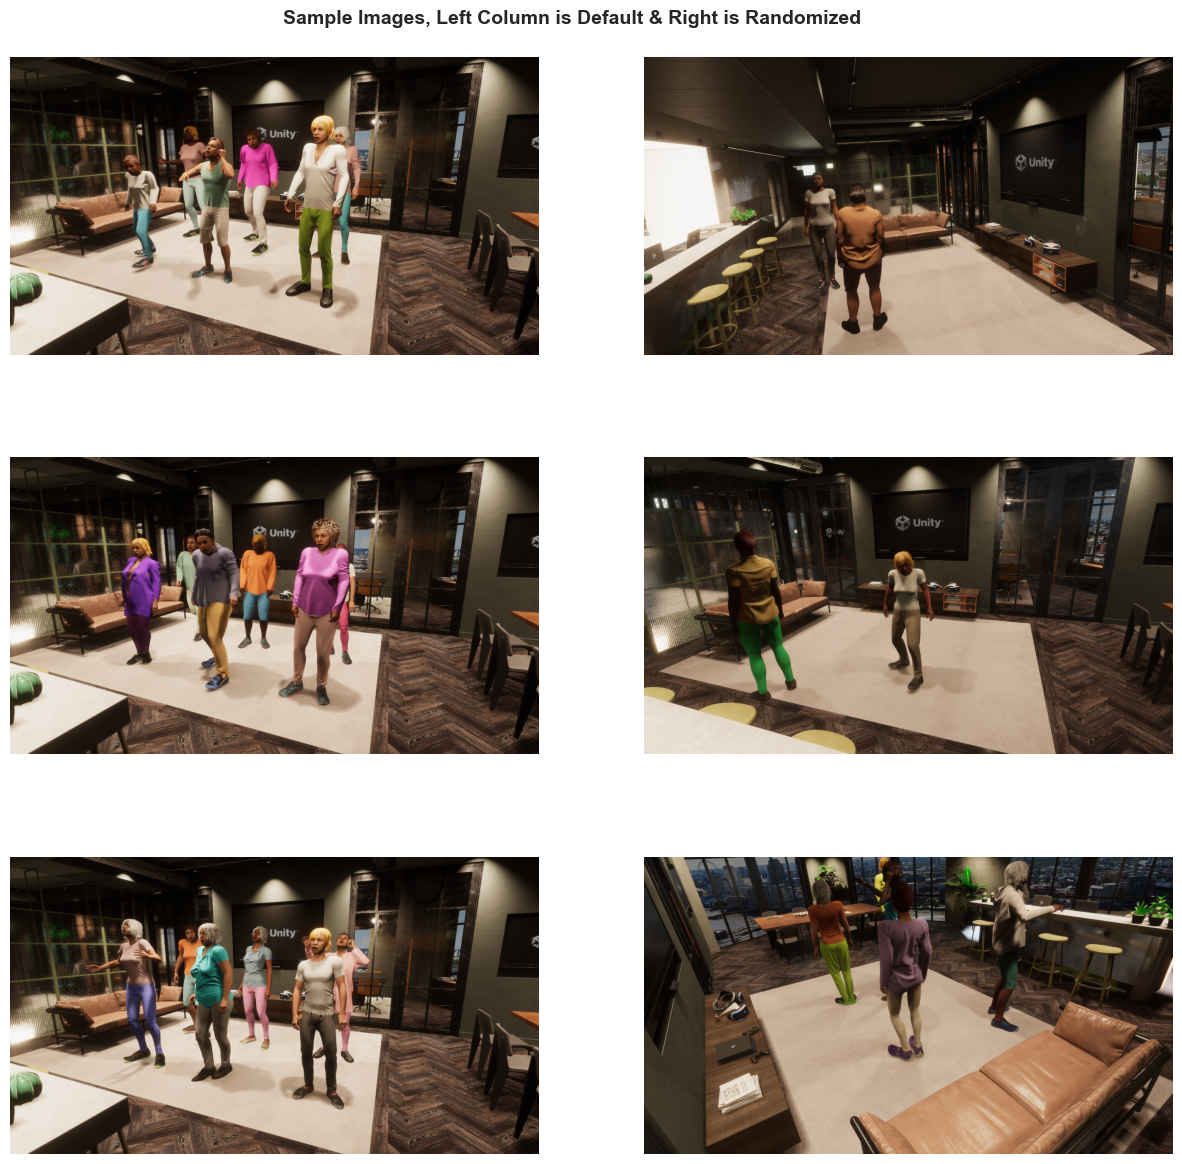

In [8]:
display_images(default_images_path, randomized_images_path)

In [9]:
json_file_a = "~/CVPR/coco-rand/annotations/keypoints.json"
randomized = convert_coco_annotations_to_df(json_file_a)
json_file_b = "~/CVPR/coco-nonrand/annotations/keypoints.json"
default = convert_coco_annotations_to_df(json_file_b)
coco_df_list = [randomized, default]

## Bounding Box Heatmap

Bounding Box Occupancy Heatmap is computed by overlaying all the bounding boxes in an image over the entire dataset. Here we used images of size 1080x1920.

In [23]:
bbox_hm = get_bbox_heatmap(default)
bbox_hm_rand = get_bbox_heatmap(randomized)

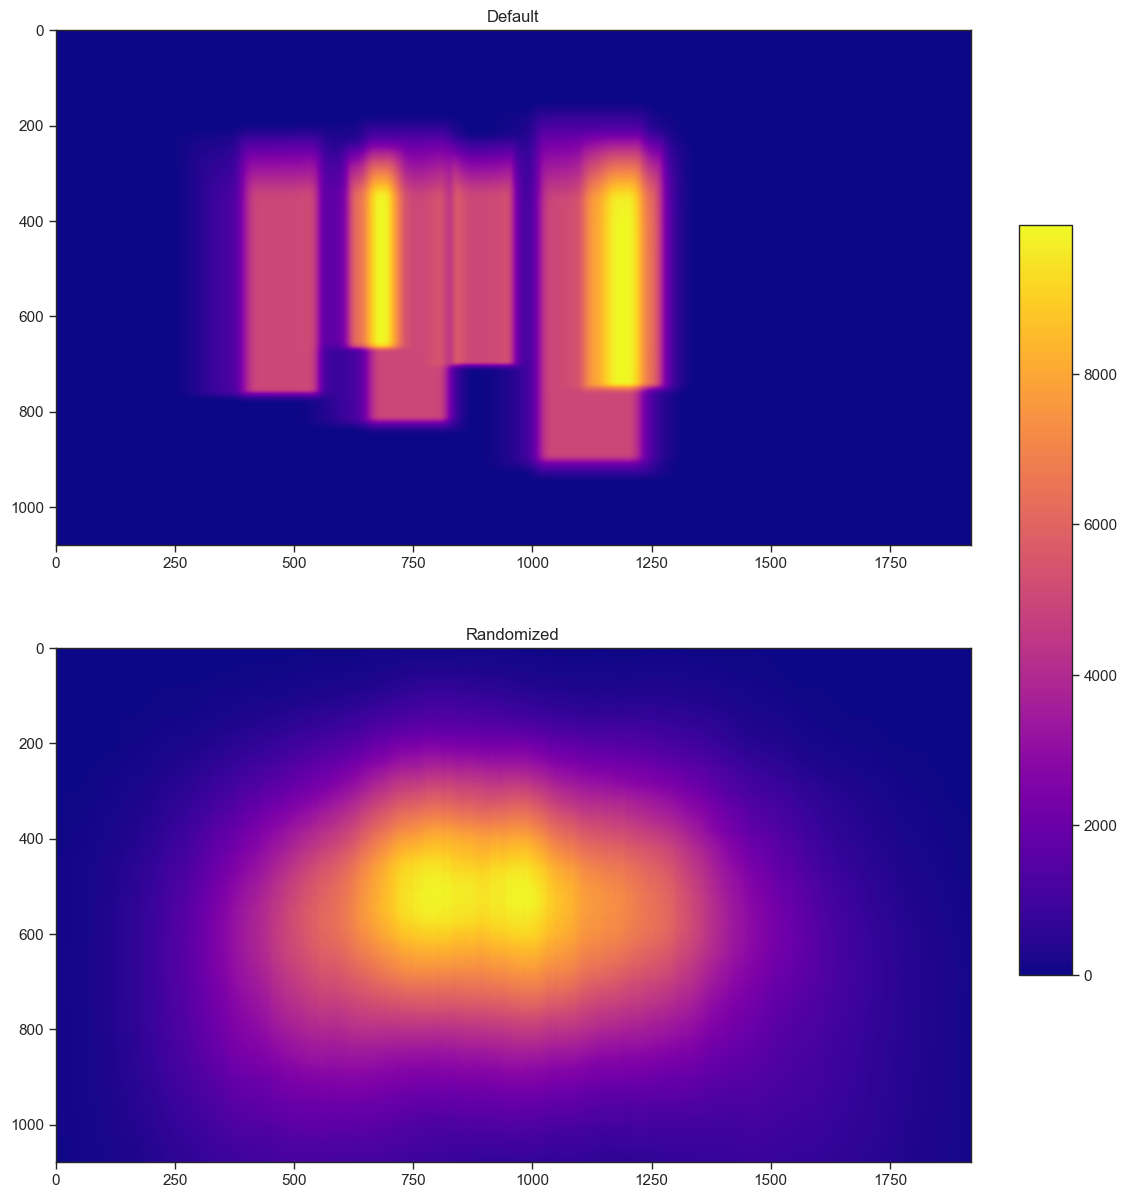

In [24]:
fig, axes = plt.subplots(dpi=100, figsize=(15,15), nrows=2 , ncols=1)
im1 = axes[0].imshow(bbox_hm[:,:,0], cmap="plasma")
axes[0].set_title('Default')
axes[1].imshow(bbox_hm_rand[:,:,0], cmap="plasma", )
axes[1].set_title('Randomized')

cbar_ax = fig.add_axes([0.85, 0.25, 0.035, 0.5])
fig.colorbar(im1, cax=cbar_ax)

plt.show()

## Bouding Box Number per Image Distribution

In [25]:
def compare_bbox_num_distribution(coco_data_list):
    data_list = ["Randomized", "Default"]
    bbox_num_df = pd.DataFrame([coco_data for coco_data in coco_data_list])
    bbox_num_df = bbox_num_df.reindex(sorted(bbox_num_df.columns), axis=1)
    bbox_num_df

    labels = bbox_num_df.columns.values.tolist()

    x = 2*np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots(dpi=100)
    fig.set_size_inches(16, 9)
    for i, coco_data in enumerate(coco_data_list):
        ax.bar(x, bbox_num_df.iloc[i].values.tolist(), width, label=data_list[i], color=COLORS[i])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Number of bouding box in a single image', fontsize=32)
    ax.set_ylabel('Probability of images in dataset', fontsize=32)
    ax.yaxis.set_tick_params(labelsize=32)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=32)
    ax.legend(fontsize=32, loc='upper left')

    fig.tight_layout()
    plt.show()
    

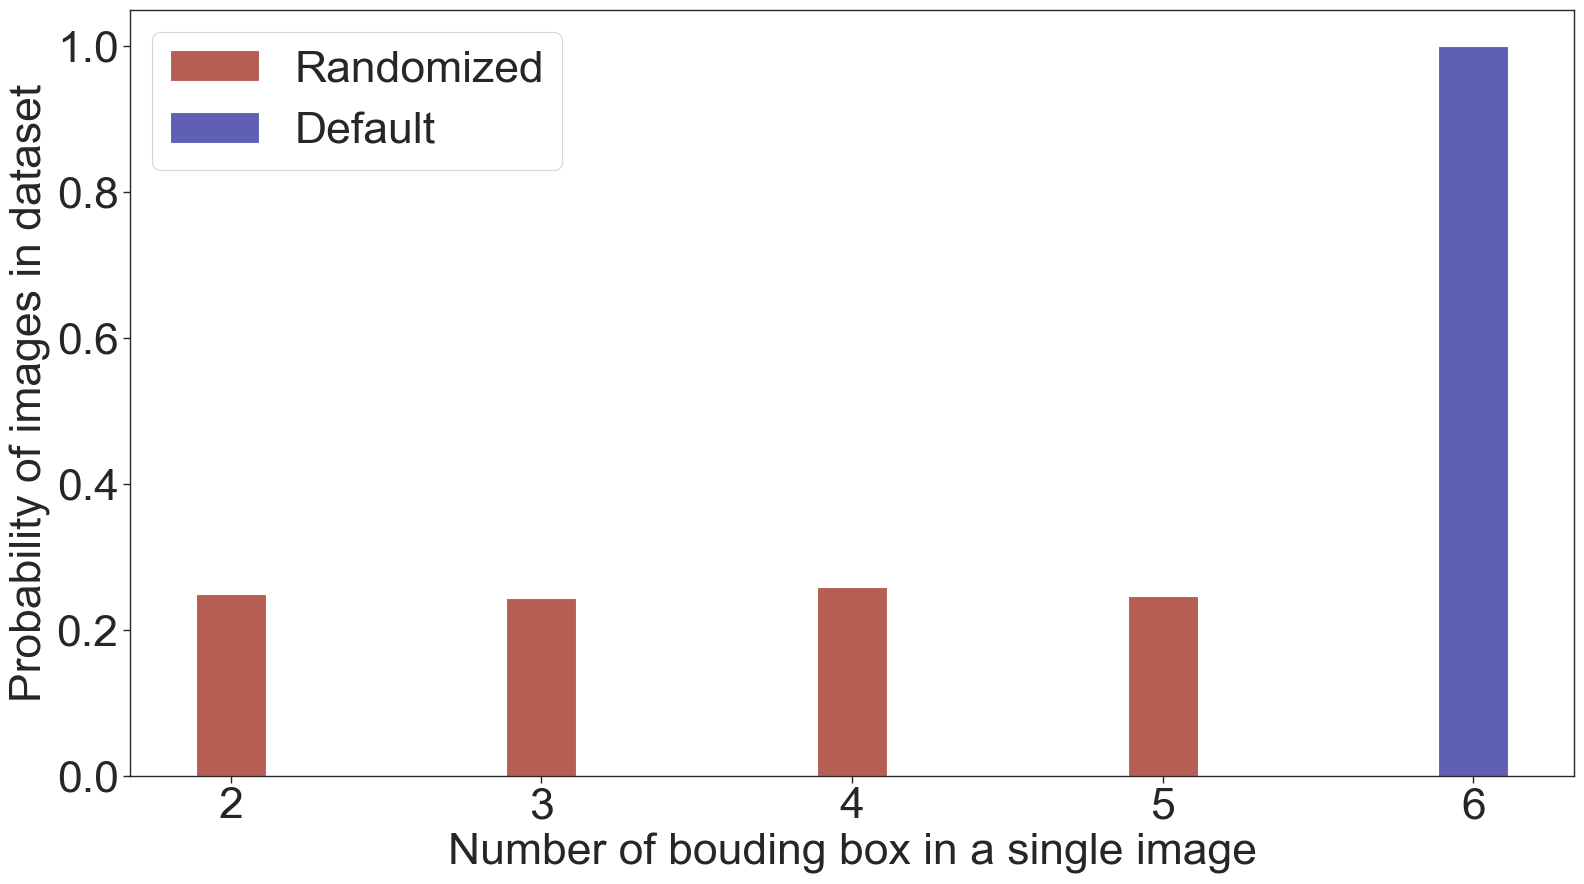

In [26]:
coco_data_list = [get_bbox_per_img_dict(df) for df in coco_df_list]
compare_bbox_num_distribution(coco_data_list)

## Visible Keypoint Distribution

In [14]:
coco_df_list[0] = coco_df_list[0].loc[coco_df_list[0]['num_keypoints'] > 5]
coco_df_list[1] = coco_df_list[1].loc[coco_df_list[1]['num_keypoints'] > 5]

In [23]:
def compare_keypoint_probability_in_bbox(coco_data_list):
    data_list = ["Randomized", "Default"]
    kpt_dict_keys = []
    for key in coco_data_list[0].keys():
        key_list = key.split("_")
        key_list = [x.capitalize() for x in key_list]
        kpt_dict_keys.append(" ".join(key_list))

    labels = kpt_dict_keys

    x = 2*np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(dpi=100)
    fig.set_size_inches(16, 9)
    for i, coco_data in enumerate(coco_data_list):
        ax.bar(x + (i-len(coco_data_list)//2)*width, coco_data.values(), width, label=data_list[i], color=COLORS[i])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probability of a keypoint in a bounding box', fontsize=24)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=24, fontweight="bold")
    ax.yaxis.set_tick_params(labelsize=24)


    legend_properties = {'weight':'bold'}
    ax.legend(fontsize=15)
    plt.legend(fontsize=15,bbox_to_anchor=(0.15, 1.15),)
    plt.xticks(rotation=60)

    fig.tight_layout()
    plt.show()

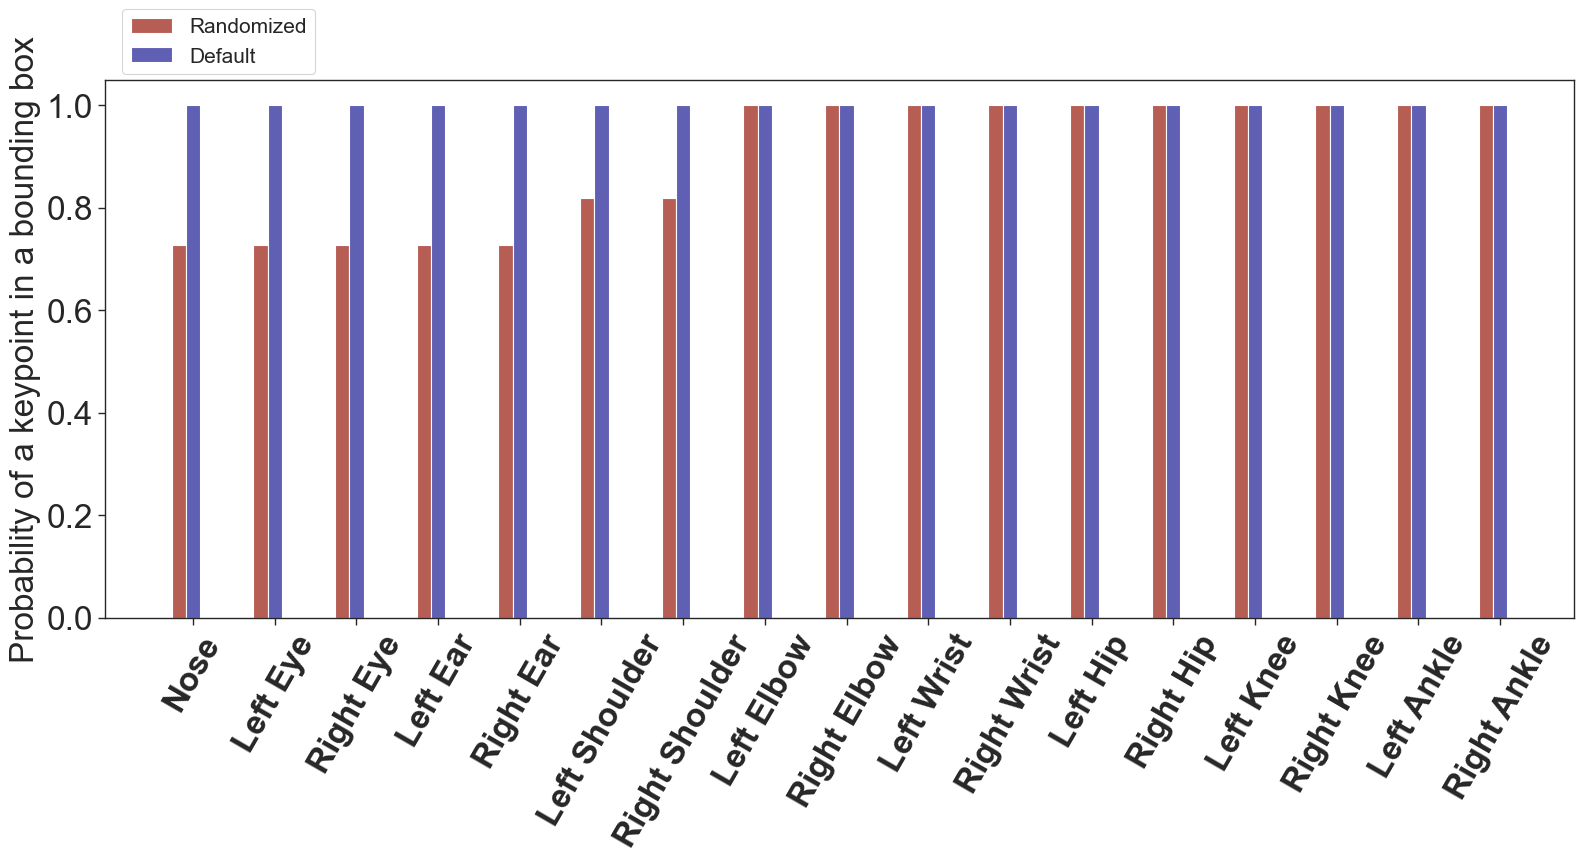

In [24]:
coco_data_list = [get_visible_keypoints_dict(df.keypoints.values.tolist()) for df in coco_df_list]
compare_keypoint_probability_in_bbox(coco_data_list)

## Bounding Box Relative Size Distribution

In [27]:
l1 = get_bbox_relative_size_list(default)
l2 = get_bbox_relative_size_list(randomized)
_def = [[x, "Default", 1/len(l1)] for x in l1]
_rand = [[x, "Randomized", 1/len(l2)] for x in l2]
df = pd.DataFrame(_def+_rand, columns =['val', 'type', 'w'])

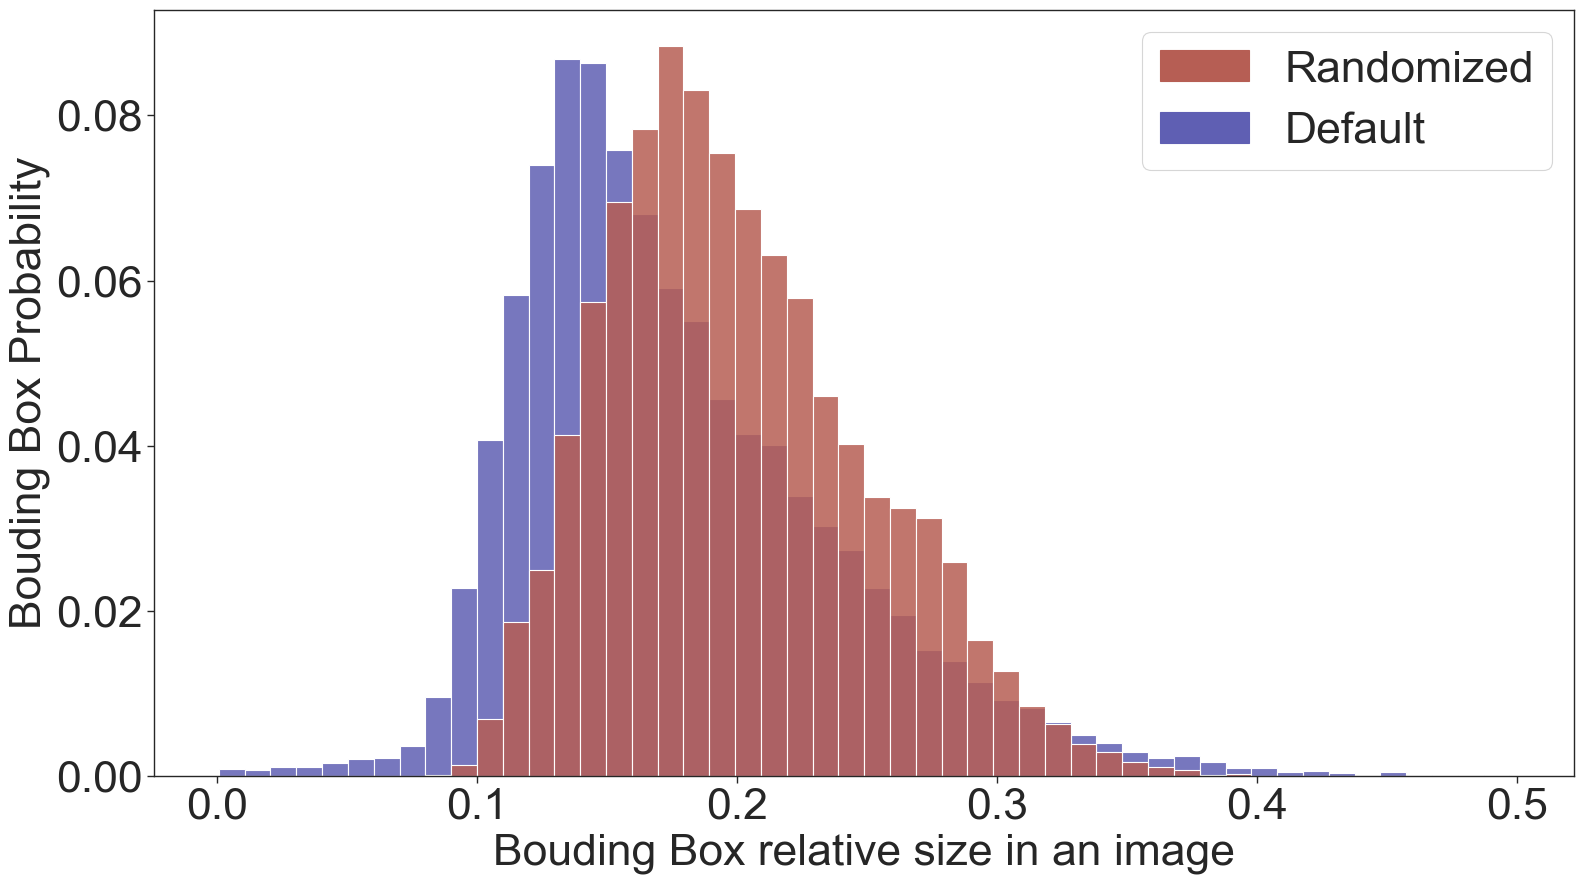

In [28]:
sns.set_palette(sns.color_palette(COLORS))
fig, ax = plt.subplots(1, 1, dpi=100,)
fig.set_size_inches(16, 9)
sns.histplot(data=df, x="val", hue="type", weights='w',  bins=50, multiple="layer", alpha=.85, ax=ax, legend=None)

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch1 = mpatches.Patch(color=COLORS[0], label='Randomized')
patch2 = mpatches.Patch(color=COLORS[1], label='Default')

handles.append(patch1) 
handles.append(patch2) 

plt.legend(handles=handles, fontsize=32)

ax.set_xlabel("Bouding Box relative size in an image", fontsize=32)
ax.set_ylabel("Bouding Box Probability", fontsize=32)
ax.yaxis.set_tick_params(labelsize=32)
ax.xaxis.set_tick_params(labelsize=32)

fig.tight_layout()
